In [141]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
import joblib
warnings.filterwarnings('ignore')

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.4f}'.format)

print("✅ Libraries loaded successfully!")

✅ Libraries loaded successfully!


In [142]:
df = pd.read_csv('data/maintenance.csv')

In [143]:
df.head()

,Robot_ID,Arm_Sensor,Vibration_Sensor,Temperature_Sensor,Pressure_Sensor
0,1,37.4500,6.9800,38.5100,156.2100
1,2,95.0700,5.3600,74.1900,144.2800
2,3,73.2000,3.1000,107.2900,8.6700
3,4,59.8700,8.1400,93.2200,103.0300
4,5,15.6000,6.8500,100.6600,114.6800


In [144]:
print(f"Shape: {df.shape}")

Shape: (500, 5)


In [145]:
print("\nColumns:", df.columns.tolist())


Columns: ['Robot_ID', 'Arm_Sensor', 'Vibration_Sensor', 'Temperature_Sensor', 'Pressure_Sensor']


In [146]:
print("\nData types:")
print(df.dtypes)


Data types:
Robot_ID                int64
Arm_Sensor            float64
Vibration_Sensor      float64
Temperature_Sensor    float64
Pressure_Sensor       float64
dtype: object


In [147]:
print("\nMissing values:")
print(df.isnull().sum())


Missing values:
Robot_ID              0
Arm_Sensor            0
Vibration_Sensor      0
Temperature_Sensor    0
Pressure_Sensor       0
dtype: int64


In [148]:
# Advanced Rolling Window Statistics

def create_rolling_features(df, sensor_columns, windows_hours=[1, 6, 12]):
    """
    Create advanced rolling window statistics

    Parameters:
    - df: DataFrame with timestamp and sensor columns
    - sensor_columns: List of sensor column names ['Arm_Sensor', 'Temperature_Sensor', 'Vibration_Sensor', 'Pressure_Sensor']
    - windows_hours: List of window sizes in hours [1, 6, 12]
    """
    df_rolling = df.copy()

    # Ensure timestamp is datetime
    if 'timestamp' in df_rolling.columns:
        df_rolling['timestamp'] = pd.to_datetime(df_rolling['timestamp'])
        df_rolling = df_rolling.sort_values('timestamp').reset_index(drop=True)

    print("Creating Rolling Window Features...")
    print("="*60)

    for sensor in sensor_columns:
        print(f"\nProcessing {sensor}...")

        for window_hours in windows_hours:
            # Assuming data is collected every minute, convert hours to rows
            # If your data frequency is different, adjust window_size accordingly
            # Example: hourly data -> window_size = window_hours
            #          minute data -> window_size = window_hours * 60
            window_size = window_hours * 60  # Adjust based on your data frequency

            # 1. Rolling Mean
            df_rolling[f'{sensor}_rolling_mean_{window_hours}h'] = \
                df_rolling[sensor].rolling(window=window_size, min_periods=1).mean()

            # 2. Rolling Standard Deviation (volatility)
            df_rolling[f'{sensor}_rolling_std_{window_hours}h'] = \
                df_rolling[sensor].rolling(window=window_size, min_periods=1).std()

            # 3. Rolling Min
            df_rolling[f'{sensor}_rolling_min_{window_hours}h'] = \
                df_rolling[sensor].rolling(window=window_size, min_periods=1).min()

            # 4. Rolling Max
            df_rolling[f'{sensor}_rolling_max_{window_hours}h'] = \
                df_rolling[sensor].rolling(window=window_size, min_periods=1).max()

            # 5. Rolling Range (max - min)
            df_rolling[f'{sensor}_rolling_range_{window_hours}h'] = \
                df_rolling[f'{sensor}_rolling_max_{window_hours}h'] - \
                df_rolling[f'{sensor}_rolling_min_{window_hours}h']

            # 6. Exponential Moving Average (EMA)
            # More weight to recent observations
            df_rolling[f'{sensor}_ema_{window_hours}h'] = \
                df_rolling[sensor].ewm(span=window_size, adjust=False).mean()

            # 7. Rolling Median (robust to outliers)
            df_rolling[f'{sensor}_rolling_median_{window_hours}h'] = \
                df_rolling[sensor].rolling(window=window_size, min_periods=1).median()

            # 8. Rolling Coefficient of Variation (CV = std/mean)
            # Measures relative variability
            rolling_mean = df_rolling[f'{sensor}_rolling_mean_{window_hours}h']
            rolling_std = df_rolling[f'{sensor}_rolling_std_{window_hours}h']
            df_rolling[f'{sensor}_rolling_cv_{window_hours}h'] = \
                rolling_std / (rolling_mean + 1e-5)  # Add small value to avoid division by zero

            print(f"  ✅ Created 8 features for {window_hours}h window")

    print("\n" + "="*60)
    print(f"Rolling features created! New shape: {df_rolling.shape}")

    return df_rolling

In [149]:
# Apply rolling window features
sensor_columns = ['Arm_Sensor', 'Temperature_Sensor', 'Vibration_Sensor', 'Pressure_Sensor']
df_features = create_rolling_features(df, sensor_columns, windows_hours=[1, 6, 12])

print(f"\n📈 Total features now: {df_features.shape[1]}")
print(f"Added {df_features.shape[1] - df.shape[1]} new rolling features")

Creating Rolling Window Features...

Processing Arm_Sensor...
  ✅ Created 8 features for 1h window
  ✅ Created 8 features for 6h window
  ✅ Created 8 features for 12h window

Processing Temperature_Sensor...
  ✅ Created 8 features for 1h window
  ✅ Created 8 features for 6h window
  ✅ Created 8 features for 12h window

Processing Vibration_Sensor...
  ✅ Created 8 features for 1h window
  ✅ Created 8 features for 6h window
  ✅ Created 8 features for 12h window

Processing Pressure_Sensor...
  ✅ Created 8 features for 1h window
  ✅ Created 8 features for 6h window
  ✅ Created 8 features for 12h window

Rolling features created! New shape: (500, 101)

📈 Total features now: 101
Added 96 new rolling features


In [150]:
#Lag Features and Time-Series Features
def create_lag_features(df, sensor_columns, lags=[1, 2, 3, 6, 12]):
    """
    Create lag features for time-series

    Parameters:
    - lags: List of lag periods (e.g., [1, 2] means t-1, t-2)
    """
    df_lagged = df.copy()

    print("Creating Lag Features...")
    print("="*60)

    for sensor in sensor_columns:
        print(f"\nProcessing {sensor}...")

        for lag in lags:
            # Create lag feature
            df_lagged[f'{sensor}_lag_{lag}'] = df_lagged[sensor].shift(lag)
            print(f"  ✅ Created lag-{lag} feature")

    print("\n" + "="*60)
    print(f"Lag features created! New shape: {df_lagged.shape}")

    return df_lagged


In [151]:
def create_rate_of_change_features(df, sensor_columns):
    """
    Create rate of change and derivative features
    """
    df_roc = df.copy()

    print("\nCreating Rate of Change Features...")
    print("="*60)

    for sensor in sensor_columns:
        # 1. First difference (change from previous time step)
        df_roc[f'{sensor}_diff_1'] = df_roc[sensor].diff(1)

        # 2. Second difference (acceleration/deceleration)
        df_roc[f'{sensor}_diff_2'] = df_roc[sensor].diff(2)

        # 3. Percentage change
        df_roc[f'{sensor}_pct_change'] = df_roc[sensor].pct_change()

        # 4. Rate of change over last 6 periods
        df_roc[f'{sensor}_roc_6'] = df_roc[sensor].diff(6) / 6

        print(f"✅ Created 4 rate-of-change features for {sensor}")

    print("\n" + "="*60)
    return df_roc

In [152]:
def create_interaction_features(df):
    """
    Create interaction features between sensors
    """
    df_inter = df.copy()

    print("\nCreating Interaction Features...")
    print("="*60)

    # Temperature × Vibration (thermal stress indicator)
    df_inter['temp_vib_product'] = df_inter['Temperature_Sensor'] * df_inter['Vibration_Sensor']

    # Temperature / Pressure (thermal-pressure ratio)
    df_inter['temp_pressure_ratio'] = df_inter['Temperature_Sensor'] / (df_inter['Pressure_Sensor'] + 1e-5)

    # Vibration × Pressure
    df_inter['vib_pressure_product'] = df_inter['Vibration_Sensor'] * df_inter['Pressure_Sensor']

    # Combined stress score
    df_inter['combined_stress'] = (
        df_inter['Temperature_Sensor'] / df_inter['Temperature_Sensor'].max() * 0.3 +
        df_inter['Vibration_Sensor'] / df_inter['Vibration_Sensor'].max() * 0.3 +
        df_inter['Pressure_Sensor'] / df_inter['Pressure_Sensor'].max() * 0.2 +
        df_inter['Arm_Sensor'] / df_inter['Arm_Sensor'].max() * 0.2
    )

    # Distance from optimal operating point
    optimal_temp = df_inter['Temperature_Sensor'].median()
    optimal_vib = df_inter['Vibration_Sensor'].median()
    optimal_pressure = df_inter['Pressure_Sensor'].median()

    df_inter['distance_from_optimal'] = np.sqrt(
        ((df_inter['Temperature_Sensor'] - optimal_temp) / optimal_temp) ** 2 +
        ((df_inter['Vibration_Sensor'] - optimal_vib) / optimal_vib) ** 2 +
        ((df_inter['Pressure_Sensor'] - optimal_pressure) / optimal_pressure) ** 2
    )

    print("✅ Created 5 interaction features")
    print("="*60)

    return df_inter

In [153]:
# Apply all feature engineering
df_features = create_lag_features(df_features, sensor_columns, lags=[1, 2, 3, 6, 12])
df_features = create_rate_of_change_features(df_features, sensor_columns)
df_features = create_interaction_features(df_features)

Creating Lag Features...

Processing Arm_Sensor...
  ✅ Created lag-1 feature
  ✅ Created lag-2 feature
  ✅ Created lag-3 feature
  ✅ Created lag-6 feature
  ✅ Created lag-12 feature

Processing Temperature_Sensor...
  ✅ Created lag-1 feature
  ✅ Created lag-2 feature
  ✅ Created lag-3 feature
  ✅ Created lag-6 feature
  ✅ Created lag-12 feature

Processing Vibration_Sensor...
  ✅ Created lag-1 feature
  ✅ Created lag-2 feature
  ✅ Created lag-3 feature
  ✅ Created lag-6 feature
  ✅ Created lag-12 feature

Processing Pressure_Sensor...
  ✅ Created lag-1 feature
  ✅ Created lag-2 feature
  ✅ Created lag-3 feature
  ✅ Created lag-6 feature
  ✅ Created lag-12 feature

Lag features created! New shape: (500, 121)

Creating Rate of Change Features...
✅ Created 4 rate-of-change features for Arm_Sensor
✅ Created 4 rate-of-change features for Temperature_Sensor
✅ Created 4 rate-of-change features for Vibration_Sensor
✅ Created 4 rate-of-change features for Pressure_Sensor


Creating Interaction 

In [154]:
print(f"Final dataset shape: {df_features.shape}")
print(f"Total features created: {df_features.shape[1] - df.shape[1]}")

Final dataset shape: (500, 142)
Total features created: 137


In [155]:
# Save the feature engineering pipeline for later use

# Remove NaN values created by lag features
df_features_clean = df_features.dropna().reset_index(drop=True)

print(f"\n💾 Saving preprocessing artifacts...")
print(f"Clean dataset shape: {df_features_clean.shape}")

# Save the cleaned dataset
df_features_clean.to_csv('features_engineered.csv', index=False)
print("✅ Saved: features_engineered.csv")

# Save feature names for reference
feature_names = [col for col in df_features_clean.columns
                if col not in ['timestamp', 'target', 'failure']]

with open('feature_names.txt', 'w') as f:
    for feature in feature_names:
        f.write(f"{feature}\n")

print(f"✅ Saved: feature_names.txt ({len(feature_names)} features)")


💾 Saving preprocessing artifacts...
Clean dataset shape: (488, 142)
✅ Saved: features_engineered.csv
✅ Saved: feature_names.txt (142 features)


In [156]:
metadata = {
    'original_shape': df.shape,
    'final_shape': df_features_clean.shape,
    'total_features': len(feature_names),
    'sensor_columns': sensor_columns,
    'windows_used': [1, 6, 12],
    'lags_used': [1, 2, 3, 6, 12]
}

In [157]:
import json
with open('metadata.json', 'w') as f:
    json.dump(metadata, f, indent=4)

print("✅ Saved: metadata.json")
print("\n" + "="*60)
print("WEEK 1 ARTIFACTS SAVED SUCCESSFULLY!")
print("="*60)

✅ Saved: metadata.json

WEEK 1 ARTIFACTS SAVED SUCCESSFULLY!


Modelling and steup

In [158]:
 #Modeling Setup

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report, confusion_matrix,
    precision_recall_curve, auc, roc_auc_score,
    precision_score, recall_score, f1_score
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN
import matplotlib.pyplot as plt
import seaborn as sns

In [159]:
df = pd.read_csv('features_engineered.csv')

In [160]:
print("📊 Dataset loaded!")
print(f"Shape: {df.shape}")

📊 Dataset loaded!
Shape: (488, 142)


In [161]:
# Assuming you have a 'target' column (1 = failure, 0 = normal)
# If not, create one based on your criteria
# Example: Create target if any sensor exceeds threshold
if 'target' not in df.columns:
    print("\n⚠️ Creating target variable based on thresholds...")
    df['target'] = (
        (df['Temperature_Sensor'] > df['Temperature_Sensor'].quantile(0.95)) |
        (df['Vibration_Sensor'] > df['Vibration_Sensor'].quantile(0.95)) |
        (df['Pressure_Sensor'] < df['Pressure_Sensor'].quantile(0.05))
    ).astype(int)


⚠️ Creating target variable based on thresholds...


In [162]:
# Check class distribution
print("\n📊 Class Distribution:")
print(df['target'].value_counts())
print(f"\nFailure rate: {df['target'].mean()*100:.2f}%")
print(f"Imbalance ratio: {(df['target']==0).sum() / (df['target']==1).sum():.1f}:1")


📊 Class Distribution:
target
0    416
1     72
Name: count, dtype: int64

Failure rate: 14.75%
Imbalance ratio: 5.8:1


In [163]:
# Separate features and target
feature_columns = [col for col in df.columns
                  if col not in ['target', 'timestamp', 'failure']]

In [164]:
X = df[feature_columns]
y = df['target']

In [165]:
print(f"\n✅ Features: {len(feature_columns)}")
print(f"✅ Samples: {len(X)}")


✅ Features: 142
✅ Samples: 488


In [166]:
# Time-series split: Use chronological order
# 70% train, 15% validation, 15% test

split_1 = int(0.7 * len(X))
split_2 = int(0.85 * len(X))

X_train = X[:split_1]
y_train = y[:split_1]

X_val = X[split_1:split_2]
y_val = y[split_1:split_2]

X_test = X[split_2:]
y_test = y[split_2:]

print(f"\n📊 Data Split:")
print(f"Train: {len(X_train)} ({len(X_train)/len(X)*100:.1f}%)")
print(f"  - Failures: {y_train.sum()} ({y_train.mean()*100:.2f}%)")
print(f"Validation: {len(X_val)} ({len(X_val)/len(X)*100:.1f}%)")
print(f"  - Failures: {y_val.sum()} ({y_val.mean()*100:.2f}%)")
print(f"Test: {len(X_test)} ({len(X_test)/len(X)*100:.1f}%)")
print(f"  - Failures: {y_test.sum()} ({y_test.mean()*100:.2f}%)")


📊 Data Split:
Train: 341 (69.9%)
  - Failures: 53 (15.54%)
Validation: 73 (15.0%)
  - Failures: 11 (15.07%)
Test: 74 (15.2%)
  - Failures: 8 (10.81%)


In [167]:
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [168]:
# Save scaler
import joblib
joblib.dump(scaler, 'scaler.pkl')
print("\n✅ Scaler saved: scaler.pkl")


✅ Scaler saved: scaler.pkl


In [169]:
# Apply SMOTE to training data only
print("\n🔄 Applying SMOTE...")

smote = SMOTE(random_state=42, k_neighbors=5)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)

print(f"Original training set: {len(X_train_scaled)}")
print(f"  - Class 0: {(y_train==0).sum()}")
print(f"  - Class 1: {(y_train==1).sum()}")

print(f"\nBalanced training set: {len(X_train_balanced)}")
print(f"  - Class 0: {(y_train_balanced==0).sum()}")
print(f"  - Class 1: {(y_train_balanced==1).sum()}")


🔄 Applying SMOTE...
Original training set: 341
  - Class 0: 288
  - Class 1: 53

Balanced training set: 576
  - Class 0: 288
  - Class 1: 288


In [170]:
# Train baseline Logistic Regression
print("\n" + "="*60)
print("BASELINE: Logistic Regression")
print("="*60)

lr_model = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')
lr_model.fit(X_train_balanced, y_train_balanced)


BASELINE: Logistic Regression


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,42
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [171]:
# Predictions
y_val_pred = lr_model.predict(X_val_scaled)
y_val_proba = lr_model.predict_proba(X_val_scaled)[:, 1]

In [172]:
# Calculate PR-AUC (PRIMARY METRIC)
precision, recall, thresholds = precision_recall_curve(y_val, y_val_proba)
pr_auc = auc(recall, precision)

print(f"\n📊 Validation Results:")
print(f"Precision: {precision_score(y_val, y_val_pred):.4f}")
print(f"Recall: {recall_score(y_val, y_val_pred):.4f}")
print(f"F1-Score: {f1_score(y_val, y_val_pred):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_val, y_val_proba):.4f}")
print(f"⭐ PR-AUC: {pr_auc:.4f} (PRIMARY METRIC)")


📊 Validation Results:
Precision: 0.3182
Recall: 0.6364
F1-Score: 0.4242
ROC-AUC: 0.7830
⭐ PR-AUC: 0.6310 (PRIMARY METRIC)


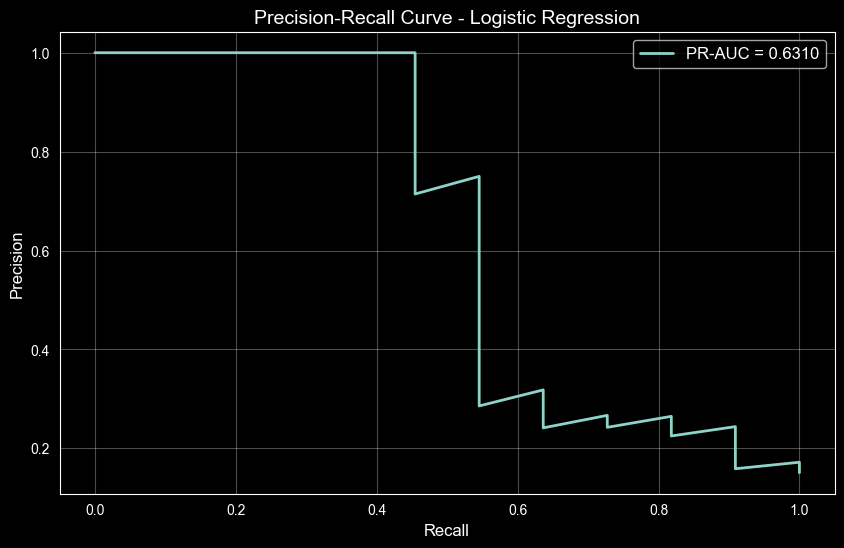

In [173]:
# Plot PR Curve
plt.figure(figsize=(10, 6))
plt.plot(recall, precision, linewidth=2, label=f'PR-AUC = {pr_auc:.4f}')
plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Precision-Recall Curve - Logistic Regression', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.savefig('pr_curve_lr.png', dpi=300, bbox_inches='tight')
plt.show()

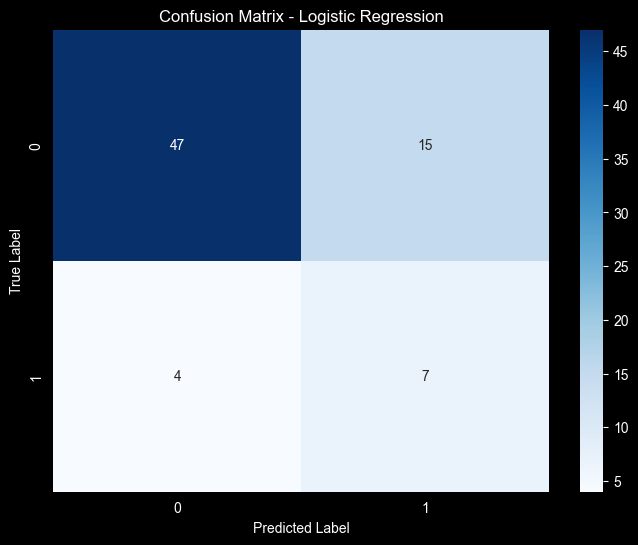

In [174]:
# Confusion Matrix
cm = confusion_matrix(y_val, y_val_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Logistic Regression')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig('confusion_matrix_lr.png', dpi=300, bbox_inches='tight')
plt.show()

In [175]:
#XGBoost Production Model

import xgboost as xgb
from xgboost import XGBClassifier

In [176]:
print("\n" + "="*60)
print("PRODUCTION MODEL: XGBoost")
print("="*60)


PRODUCTION MODEL: XGBoost


In [177]:
# Calculate scale_pos_weight for imbalance
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
print(f"\nScale pos weight: {scale_pos_weight:.2f}")


Scale pos weight: 5.43


In [178]:
# Train XGBoost with class weights (NO SMOTE needed)
xgb_model = XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    scale_pos_weight=scale_pos_weight,  # Handle imbalance
    random_state=42,
    eval_metric='aucpr',  # Use PR-AUC as metric
    early_stopping_rounds=20,
    n_jobs=-1
)

In [179]:
# Train with validation set for early stopping
xgb_model.fit(
    X_train_scaled, y_train,
    eval_set=[(X_val_scaled, y_val)],
    verbose=10
)

[0]	validation_0-aucpr:0.35510
[10]	validation_0-aucpr:0.94886
[20]	validation_0-aucpr:0.99209
[30]	validation_0-aucpr:1.00000
[40]	validation_0-aucpr:1.00000
[42]	validation_0-aucpr:1.00000


,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,20
,enable_categorical,False
,eval_metric,'aucpr'


In [180]:
# Predictions
y_val_pred_xgb = xgb_model.predict(X_val_scaled)
y_val_proba_xgb = xgb_model.predict_proba(X_val_scaled)[:, 1]

In [181]:
# Calculate metrics
precision_xgb, recall_xgb, _ = precision_recall_curve(y_val, y_val_proba_xgb)
pr_auc_xgb = auc(recall_xgb, precision_xgb)

print(f"\n📊 XGBoost Validation Results:")
print(f"Precision: {precision_score(y_val, y_val_pred_xgb):.4f}")
print(f"Recall: {recall_score(y_val, y_val_pred_xgb):.4f}")
print(f"F1-Score: {f1_score(y_val, y_val_pred_xgb):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_val, y_val_proba_xgb):.4f}")
print(f"⭐ PR-AUC: {pr_auc_xgb:.4f}")



📊 XGBoost Validation Results:
Precision: 1.0000
Recall: 0.9091
F1-Score: 0.9524
ROC-AUC: 1.0000
⭐ PR-AUC: 1.0000


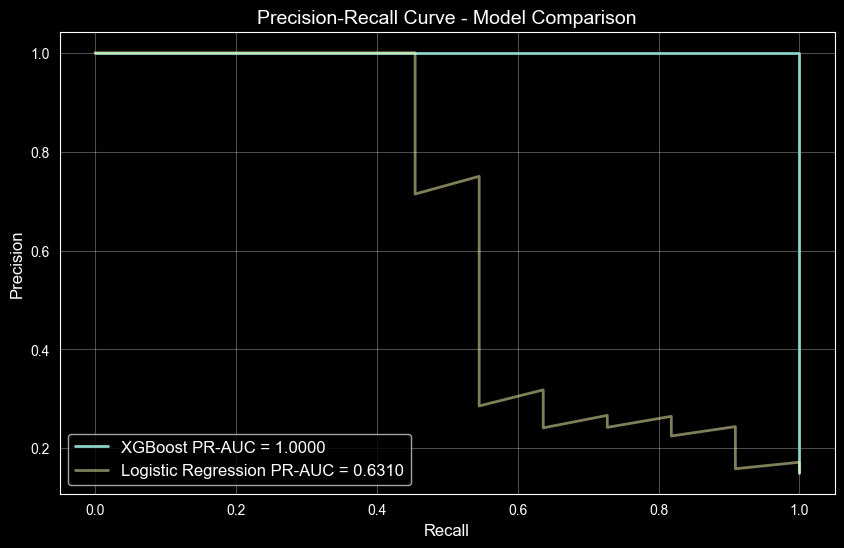

In [182]:
# Plot PR Curve
plt.figure(figsize=(10, 6))
plt.plot(recall_xgb, precision_xgb, linewidth=2, label=f'XGBoost PR-AUC = {pr_auc_xgb:.4f}')
plt.plot(recall, precision, linewidth=2, alpha=0.5, label=f'Logistic Regression PR-AUC = {pr_auc:.4f}')
plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Precision-Recall Curve - Model Comparison', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.savefig('pr_curve_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

In [183]:

# Feature Importance
feature_importance = pd.DataFrame({
    'Feature': feature_columns,
    'Importance': xgb_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\n📊 Top 10 Most Important Features:")
print(feature_importance.head(10).to_string(index=False))


📊 Top 10 Most Important Features:
                             Feature  Importance
               distance_from_optimal      0.2142
                  Temperature_Sensor      0.1270
                   Arm_Sensor_ema_1h      0.1213
                     combined_stress      0.0813
           Temperature_Sensor_diff_2      0.0796
                     Pressure_Sensor      0.0770
                 temp_pressure_ratio      0.0625
               Arm_Sensor_pct_change      0.0502
Temperature_Sensor_rolling_median_1h      0.0492
     Vibration_Sensor_rolling_max_1h      0.0489


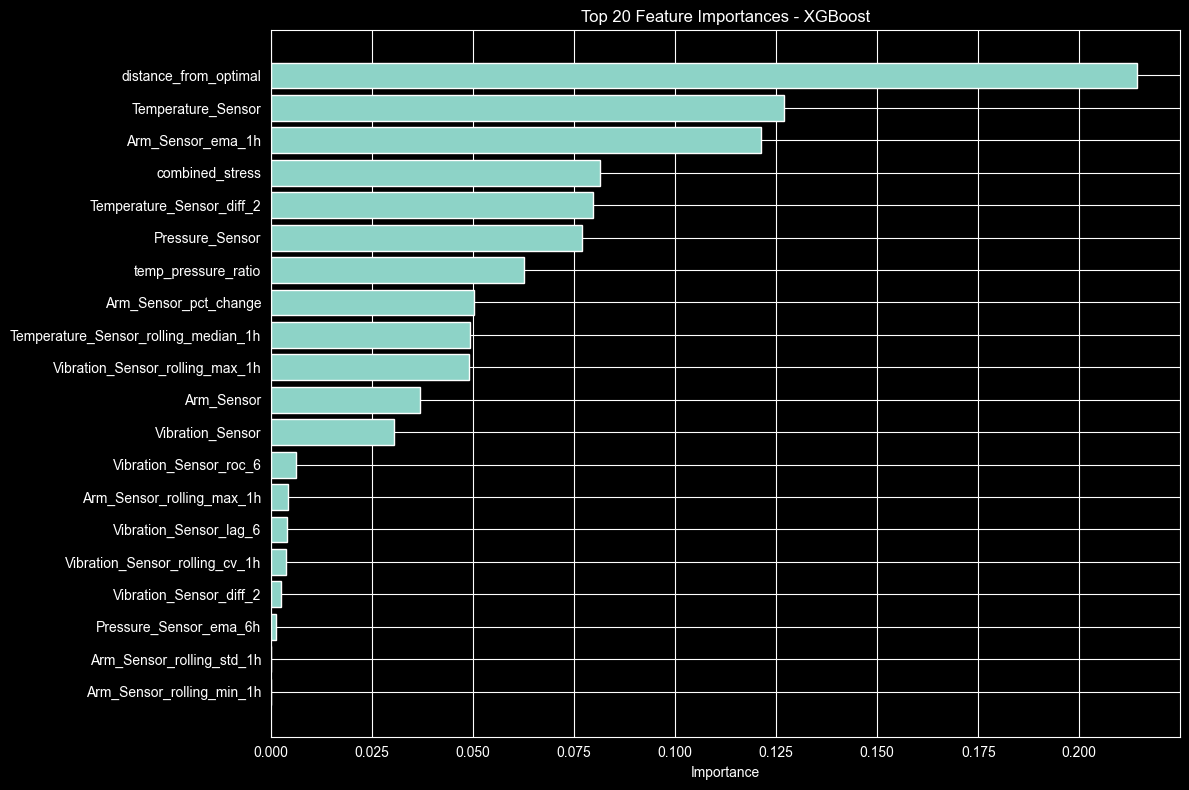

In [184]:
# Plot feature importance
plt.figure(figsize=(12, 8))
top_20 = feature_importance.head(20)
plt.barh(range(len(top_20)), top_20['Importance'])
plt.yticks(range(len(top_20)), top_20['Feature'])
plt.xlabel('Importance')
plt.title('Top 20 Feature Importances - XGBoost')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('feature_importance_xgb.png', dpi=300, bbox_inches='tight')
plt.show()

In [185]:
%pip install optuna

Note: you may need to restart the kernel to use updated packages.


In [186]:
# Optuna Optimization

import optuna
from optuna.visualization import plot_optimization_history, plot_param_importances


In [187]:
def objective(trial):
    """
    Optuna objective function for XGBoost
    """
    # Suggest hyperparameters
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'scale_pos_weight': scale_pos_weight,
        'random_state': 42,
        'eval_metric': 'aucpr',
        'n_jobs': -1
    }

    # Train model
    model = XGBClassifier(**params)
    model.fit(
        X_train_scaled, y_train,
        eval_set=[(X_val_scaled, y_val)],
        verbose=0
    )

    # Predict
    y_val_proba = model.predict_proba(X_val_scaled)[:, 1]

    # Calculate PR-AUC
    precision, recall, _ = precision_recall_curve(y_val, y_val_proba)
    pr_auc = auc(recall, precision)

    return pr_auc

In [188]:
# Run Optuna optimization
print("\n" + "="*60)
print("HYPERPARAMETER OPTIMIZATION WITH OPTUNA")
print("="*60)
print("This will take 10-20 minutes...")


HYPERPARAMETER OPTIMIZATION WITH OPTUNA
This will take 10-20 minutes...


In [189]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50, show_progress_bar=True)

[I 2025-12-30 23:22:10,173] A new study created in memory with name: no-name-9e5a6633-b295-455c-8f2b-bc13b2dd71dc
Best trial: 0. Best value: 1:   2%|▏         | 1/50 [00:00<00:16,  3.02it/s]

[I 2025-12-30 23:22:10,500] Trial 0 finished with value: 1.0 and parameters: {'n_estimators': 337, 'max_depth': 5, 'learning_rate': 0.0431076676788831, 'subsample': 0.8896170614300907, 'colsample_bytree': 0.8817990403222054, 'min_child_weight': 6, 'gamma': 1.9770254037047807}. Best is trial 0 with value: 1.0.


Best trial: 0. Best value: 1:   4%|▍         | 2/50 [00:00<00:13,  3.61it/s]

[I 2025-12-30 23:22:10,737] Trial 1 finished with value: 1.0 and parameters: {'n_estimators': 322, 'max_depth': 5, 'learning_rate': 0.05413857887232626, 'subsample': 0.9295232674626578, 'colsample_bytree': 0.7487921352743135, 'min_child_weight': 8, 'gamma': 4.885207951145397}. Best is trial 0 with value: 1.0.


Best trial: 0. Best value: 1:   6%|▌         | 3/50 [00:00<00:11,  4.18it/s]

[I 2025-12-30 23:22:10,928] Trial 2 finished with value: 0.9920798898071624 and parameters: {'n_estimators': 117, 'max_depth': 7, 'learning_rate': 0.037036036455845606, 'subsample': 0.983637143669798, 'colsample_bytree': 0.7711134287968127, 'min_child_weight': 9, 'gamma': 2.47395498172179}. Best is trial 0 with value: 1.0.


Best trial: 0. Best value: 1:   8%|▊         | 4/50 [00:01<00:12,  3.77it/s]

[I 2025-12-30 23:22:11,238] Trial 3 finished with value: 0.9834022038567493 and parameters: {'n_estimators': 346, 'max_depth': 9, 'learning_rate': 0.02866487923748079, 'subsample': 0.9449681736549846, 'colsample_bytree': 0.6824913227543059, 'min_child_weight': 10, 'gamma': 2.9478334094966394}. Best is trial 0 with value: 1.0.


Best trial: 0. Best value: 1:  12%|█▏        | 6/50 [00:01<00:09,  4.75it/s]

[I 2025-12-30 23:22:11,471] Trial 4 finished with value: 0.9508985963531418 and parameters: {'n_estimators': 196, 'max_depth': 7, 'learning_rate': 0.03145865278281277, 'subsample': 0.7892564687648244, 'colsample_bytree': 0.9741053121975851, 'min_child_weight': 10, 'gamma': 2.1576736606166853}. Best is trial 0 with value: 1.0.
[I 2025-12-30 23:22:11,597] Trial 5 finished with value: 0.9920798898071626 and parameters: {'n_estimators': 176, 'max_depth': 8, 'learning_rate': 0.19631933447339472, 'subsample': 0.9413927846125332, 'colsample_bytree': 0.8741804911869007, 'min_child_weight': 10, 'gamma': 3.4418008204674564}. Best is trial 0 with value: 1.0.


Best trial: 0. Best value: 1:  14%|█▍        | 7/50 [00:01<00:08,  5.00it/s]

[I 2025-12-30 23:22:11,776] Trial 6 finished with value: 1.0 and parameters: {'n_estimators': 105, 'max_depth': 8, 'learning_rate': 0.0669108576209342, 'subsample': 0.6941490835637292, 'colsample_bytree': 0.6063570238241591, 'min_child_weight': 2, 'gamma': 2.1049067552089618}. Best is trial 0 with value: 1.0.


Best trial: 0. Best value: 1:  16%|█▌        | 8/50 [00:01<00:09,  4.36it/s]

[I 2025-12-30 23:22:12,068] Trial 7 finished with value: 1.0 and parameters: {'n_estimators': 351, 'max_depth': 6, 'learning_rate': 0.04324676718503143, 'subsample': 0.9066236023699046, 'colsample_bytree': 0.6931750806976075, 'min_child_weight': 5, 'gamma': 2.5991793341717253}. Best is trial 0 with value: 1.0.


Best trial: 0. Best value: 1:  18%|█▊        | 9/50 [00:02<00:10,  3.77it/s]

[I 2025-12-30 23:22:12,410] Trial 8 finished with value: 1.0 and parameters: {'n_estimators': 290, 'max_depth': 5, 'learning_rate': 0.024172980403551418, 'subsample': 0.6219010082002494, 'colsample_bytree': 0.7824895736250651, 'min_child_weight': 3, 'gamma': 1.109072185931181}. Best is trial 0 with value: 1.0.


Best trial: 0. Best value: 1:  20%|██        | 10/50 [00:02<00:13,  2.96it/s]

[I 2025-12-30 23:22:12,912] Trial 9 finished with value: 1.0 and parameters: {'n_estimators': 484, 'max_depth': 5, 'learning_rate': 0.021237995198298724, 'subsample': 0.9269761199923507, 'colsample_bytree': 0.8660810466483899, 'min_child_weight': 1, 'gamma': 2.4778738612787423}. Best is trial 0 with value: 1.0.


Best trial: 0. Best value: 1:  22%|██▏       | 11/50 [00:03<00:15,  2.54it/s]

[I 2025-12-30 23:22:13,431] Trial 10 finished with value: 1.0 and parameters: {'n_estimators': 459, 'max_depth': 3, 'learning_rate': 0.010118205339035034, 'subsample': 0.8244956676245433, 'colsample_bytree': 0.9770593049595306, 'min_child_weight': 7, 'gamma': 0.4692892396681727}. Best is trial 0 with value: 1.0.


Best trial: 0. Best value: 1:  24%|██▍       | 12/50 [00:03<00:13,  2.92it/s]

[I 2025-12-30 23:22:13,657] Trial 11 finished with value: 1.0 and parameters: {'n_estimators': 304, 'max_depth': 3, 'learning_rate': 0.1025549558467099, 'subsample': 0.8477522286363025, 'colsample_bytree': 0.8809616645707645, 'min_child_weight': 7, 'gamma': 4.573651544323924}. Best is trial 0 with value: 1.0.


Best trial: 0. Best value: 1:  26%|██▌       | 13/50 [00:03<00:12,  3.07it/s]

[I 2025-12-30 23:22:13,946] Trial 12 finished with value: 1.0 and parameters: {'n_estimators': 402, 'max_depth': 5, 'learning_rate': 0.08471061330187922, 'subsample': 0.8664267768279763, 'colsample_bytree': 0.8314734258422366, 'min_child_weight': 6, 'gamma': 4.59622656277344}. Best is trial 0 with value: 1.0.


Best trial: 0. Best value: 1:  28%|██▊       | 14/50 [00:03<00:10,  3.48it/s]

[I 2025-12-30 23:22:14,142] Trial 13 finished with value: 1.0 and parameters: {'n_estimators': 253, 'max_depth': 4, 'learning_rate': 0.12455083768352539, 'subsample': 0.737205276631246, 'colsample_bytree': 0.7316491478686127, 'min_child_weight': 4, 'gamma': 3.6613685822368636}. Best is trial 0 with value: 1.0.


Best trial: 0. Best value: 1:  30%|███       | 15/50 [00:04<00:09,  3.64it/s]

[I 2025-12-30 23:22:14,388] Trial 14 finished with value: 0.9920798898071626 and parameters: {'n_estimators': 420, 'max_depth': 6, 'learning_rate': 0.29705527303770773, 'subsample': 0.9915510610660354, 'colsample_bytree': 0.9273601439541044, 'min_child_weight': 8, 'gamma': 1.3461837283634703}. Best is trial 0 with value: 1.0.


Best trial: 0. Best value: 1:  32%|███▏      | 16/50 [00:04<00:10,  3.13it/s]

[I 2025-12-30 23:22:14,810] Trial 15 finished with value: 1.0 and parameters: {'n_estimators': 367, 'max_depth': 4, 'learning_rate': 0.01527530339150256, 'subsample': 0.8849236986037754, 'colsample_bytree': 0.8101932576750924, 'min_child_weight': 6, 'gamma': 3.9154859565589417}. Best is trial 0 with value: 1.0.


Best trial: 0. Best value: 1:  34%|███▍      | 17/50 [00:04<00:10,  3.29it/s]

[I 2025-12-30 23:22:15,079] Trial 16 finished with value: 0.9630739210284665 and parameters: {'n_estimators': 265, 'max_depth': 10, 'learning_rate': 0.05336432169175143, 'subsample': 0.7821317798773367, 'colsample_bytree': 0.9205211177613178, 'min_child_weight': 8, 'gamma': 0.007742674260597937}. Best is trial 0 with value: 1.0.


Best trial: 0. Best value: 1:  36%|███▌      | 18/50 [00:05<00:08,  3.59it/s]

[I 2025-12-30 23:22:15,298] Trial 17 finished with value: 1.0 and parameters: {'n_estimators': 227, 'max_depth': 4, 'learning_rate': 0.06545669150002212, 'subsample': 0.8867393741740749, 'colsample_bytree': 0.7412042716956229, 'min_child_weight': 5, 'gamma': 4.951137180595928}. Best is trial 0 with value: 1.0.


Best trial: 0. Best value: 1:  38%|███▊      | 19/50 [00:05<00:08,  3.77it/s]

[I 2025-12-30 23:22:15,534] Trial 18 finished with value: 0.9834022038567493 and parameters: {'n_estimators': 317, 'max_depth': 6, 'learning_rate': 0.13525665595267375, 'subsample': 0.9588929326220773, 'colsample_bytree': 0.6236450098397158, 'min_child_weight': 8, 'gamma': 1.6303973069710762}. Best is trial 0 with value: 1.0.


Best trial: 0. Best value: 1:  40%|████      | 20/50 [00:05<00:08,  3.67it/s]

[I 2025-12-30 23:22:15,822] Trial 19 finished with value: 1.0 and parameters: {'n_estimators': 402, 'max_depth': 5, 'learning_rate': 0.04733835844266775, 'subsample': 0.8208961511053339, 'colsample_bytree': 0.6742764595555047, 'min_child_weight': 4, 'gamma': 3.1896921801040445}. Best is trial 0 with value: 1.0.


Best trial: 0. Best value: 1:  42%|████▏     | 21/50 [00:06<00:09,  3.20it/s]

[I 2025-12-30 23:22:16,227] Trial 20 finished with value: 0.9920798898071624 and parameters: {'n_estimators': 325, 'max_depth': 4, 'learning_rate': 0.017581584860306285, 'subsample': 0.7540380982468355, 'colsample_bytree': 0.8229083609562707, 'min_child_weight': 7, 'gamma': 0.7652691662274984}. Best is trial 0 with value: 1.0.


Best trial: 0. Best value: 1:  44%|████▍     | 22/50 [00:06<00:07,  3.60it/s]

[I 2025-12-30 23:22:16,426] Trial 21 finished with value: 1.0 and parameters: {'n_estimators': 108, 'max_depth': 8, 'learning_rate': 0.06881655690614473, 'subsample': 0.6730669420442095, 'colsample_bytree': 0.6066238691274305, 'min_child_weight': 1, 'gamma': 1.8707634047309831}. Best is trial 0 with value: 1.0.


Best trial: 0. Best value: 1:  46%|████▌     | 23/50 [00:06<00:07,  3.77it/s]

[I 2025-12-30 23:22:16,660] Trial 22 finished with value: 1.0 and parameters: {'n_estimators': 175, 'max_depth': 8, 'learning_rate': 0.07357818197609892, 'subsample': 0.6911569470190285, 'colsample_bytree': 0.6449784834978802, 'min_child_weight': 2, 'gamma': 2.015626946718227}. Best is trial 0 with value: 1.0.


Best trial: 0. Best value: 1:  48%|████▊     | 24/50 [00:06<00:07,  3.58it/s]

[I 2025-12-30 23:22:16,973] Trial 23 finished with value: 1.0 and parameters: {'n_estimators': 375, 'max_depth': 7, 'learning_rate': 0.05419467556305691, 'subsample': 0.6107439295879895, 'colsample_bytree': 0.7508473585049251, 'min_child_weight': 3, 'gamma': 4.050513175349771}. Best is trial 0 with value: 1.0.


Best trial: 0. Best value: 1:  50%|█████     | 25/50 [00:07<00:06,  3.59it/s]

[I 2025-12-30 23:22:17,249] Trial 24 finished with value: 1.0 and parameters: {'n_estimators': 275, 'max_depth': 9, 'learning_rate': 0.03818591368135467, 'subsample': 0.6937593393253746, 'colsample_bytree': 0.7079636482720375, 'min_child_weight': 6, 'gamma': 1.560044042325848}. Best is trial 0 with value: 1.0.


Best trial: 0. Best value: 1:  52%|█████▏    | 26/50 [00:07<00:06,  3.88it/s]

[I 2025-12-30 23:22:17,458] Trial 25 finished with value: 1.0 and parameters: {'n_estimators': 238, 'max_depth': 6, 'learning_rate': 0.09273071974521366, 'subsample': 0.7318548244049595, 'colsample_bytree': 0.9217794483338642, 'min_child_weight': 4, 'gamma': 2.776922873976604}. Best is trial 0 with value: 1.0.


Best trial: 0. Best value: 1:  54%|█████▍    | 27/50 [00:07<00:06,  3.82it/s]

[I 2025-12-30 23:22:17,730] Trial 26 finished with value: 0.9368293322838778 and parameters: {'n_estimators': 436, 'max_depth': 9, 'learning_rate': 0.15904205013595962, 'subsample': 0.9110542504838529, 'colsample_bytree': 0.6559350731224161, 'min_child_weight': 9, 'gamma': 2.1426218014463427}. Best is trial 0 with value: 1.0.


Best trial: 0. Best value: 1:  56%|█████▌    | 28/50 [00:07<00:05,  4.03it/s]

[I 2025-12-30 23:22:17,947] Trial 27 finished with value: 1.0 and parameters: {'n_estimators': 161, 'max_depth': 10, 'learning_rate': 0.06150793693537373, 'subsample': 0.8526852904965836, 'colsample_bytree': 0.8477463081067628, 'min_child_weight': 2, 'gamma': 1.0248856399505135}. Best is trial 0 with value: 1.0.


Best trial: 0. Best value: 1:  58%|█████▊    | 29/50 [00:08<00:05,  4.16it/s]

[I 2025-12-30 23:22:18,170] Trial 28 finished with value: 1.0 and parameters: {'n_estimators': 137, 'max_depth': 5, 'learning_rate': 0.030304081316045978, 'subsample': 0.9673593972496077, 'colsample_bytree': 0.7849853147878763, 'min_child_weight': 5, 'gamma': 3.136946397531381}. Best is trial 0 with value: 1.0.


Best trial: 0. Best value: 1:  60%|██████    | 30/50 [00:08<00:04,  4.18it/s]

[I 2025-12-30 23:22:18,405] Trial 29 finished with value: 1.0 and parameters: {'n_estimators': 214, 'max_depth': 7, 'learning_rate': 0.044657054630610406, 'subsample': 0.8174351925252342, 'colsample_bytree': 0.8988738815083184, 'min_child_weight': 9, 'gamma': 2.3909760108932328}. Best is trial 0 with value: 1.0.


Best trial: 0. Best value: 1:  62%|██████▏   | 31/50 [00:08<00:05,  3.59it/s]

[I 2025-12-30 23:22:18,776] Trial 30 finished with value: 1.0 and parameters: {'n_estimators': 336, 'max_depth': 8, 'learning_rate': 0.03777962274640339, 'subsample': 0.9764249041983061, 'colsample_bytree': 0.9977525286945856, 'min_child_weight': 7, 'gamma': 1.8057177808522606}. Best is trial 0 with value: 1.0.


Best trial: 0. Best value: 1:  64%|██████▍   | 32/50 [00:08<00:05,  3.51it/s]

[I 2025-12-30 23:22:19,075] Trial 31 finished with value: 1.0 and parameters: {'n_estimators': 364, 'max_depth': 6, 'learning_rate': 0.0476551772037456, 'subsample': 0.9090223617921931, 'colsample_bytree': 0.6007687323240494, 'min_child_weight': 5, 'gamma': 2.5329998470256965}. Best is trial 0 with value: 1.0.


Best trial: 0. Best value: 1:  66%|██████▌   | 33/50 [00:09<00:05,  3.36it/s]

[I 2025-12-30 23:22:19,401] Trial 32 finished with value: 1.0 and parameters: {'n_estimators': 354, 'max_depth': 6, 'learning_rate': 0.0384515571519927, 'subsample': 0.8929151376934639, 'colsample_bytree': 0.7091582254887788, 'min_child_weight': 3, 'gamma': 2.9277407448963633}. Best is trial 0 with value: 1.0.


Best trial: 0. Best value: 1:  68%|██████▊   | 34/50 [00:09<00:05,  2.93it/s]

[I 2025-12-30 23:22:19,844] Trial 33 finished with value: 1.0 and parameters: {'n_estimators': 296, 'max_depth': 7, 'learning_rate': 0.024965091418794532, 'subsample': 0.9284335958170973, 'colsample_bytree': 0.6975900919082961, 'min_child_weight': 2, 'gamma': 1.3373899230132964}. Best is trial 0 with value: 1.0.


Best trial: 0. Best value: 1:  70%|███████   | 35/50 [00:09<00:04,  3.04it/s]

[I 2025-12-30 23:22:20,143] Trial 34 finished with value: 0.9201626656172112 and parameters: {'n_estimators': 334, 'max_depth': 7, 'learning_rate': 0.032829073327133404, 'subsample': 0.6472508540081323, 'colsample_bytree': 0.7661621398304631, 'min_child_weight': 8, 'gamma': 2.6535376528606367}. Best is trial 0 with value: 1.0.


Best trial: 0. Best value: 1:  72%|███████▏  | 36/50 [00:10<00:04,  3.25it/s]

[I 2025-12-30 23:22:20,404] Trial 35 finished with value: 1.0 and parameters: {'n_estimators': 378, 'max_depth': 5, 'learning_rate': 0.07499149184628487, 'subsample': 0.9462483671347436, 'colsample_bytree': 0.6647636265687986, 'min_child_weight': 9, 'gamma': 2.278023109606146}. Best is trial 0 with value: 1.0.


Best trial: 0. Best value: 1:  74%|███████▍  | 37/50 [00:10<00:03,  3.45it/s]

[I 2025-12-30 23:22:20,652] Trial 36 finished with value: 0.9834022038567493 and parameters: {'n_estimators': 283, 'max_depth': 6, 'learning_rate': 0.05646328797843328, 'subsample': 0.8638512935841834, 'colsample_bytree': 0.6371791620949524, 'min_child_weight': 10, 'gamma': 3.537883426078274}. Best is trial 0 with value: 1.0.


Best trial: 0. Best value: 1:  76%|███████▌  | 38/50 [00:10<00:03,  3.47it/s]

[I 2025-12-30 23:22:20,936] Trial 37 finished with value: 1.0 and parameters: {'n_estimators': 389, 'max_depth': 4, 'learning_rate': 0.09928798713529013, 'subsample': 0.9978156244807747, 'colsample_bytree': 0.6836697615937586, 'min_child_weight': 6, 'gamma': 4.201510282763375}. Best is trial 0 with value: 1.0.


Best trial: 0. Best value: 1:  78%|███████▊  | 39/50 [00:11<00:03,  3.12it/s]

[I 2025-12-30 23:22:21,333] Trial 38 finished with value: 1.0 and parameters: {'n_estimators': 311, 'max_depth': 9, 'learning_rate': 0.026519644576515095, 'subsample': 0.7684058887908821, 'colsample_bytree': 0.715627186549649, 'min_child_weight': 4, 'gamma': 0.5395549076092259}. Best is trial 0 with value: 1.0.


Best trial: 0. Best value: 1:  80%|████████  | 40/50 [00:11<00:03,  3.03it/s]

[I 2025-12-30 23:22:21,684] Trial 39 finished with value: 1.0 and parameters: {'n_estimators': 352, 'max_depth': 3, 'learning_rate': 0.01967221826528483, 'subsample': 0.9168431727190525, 'colsample_bytree': 0.7979737600666132, 'min_child_weight': 1, 'gamma': 4.983124435170806}. Best is trial 0 with value: 1.0.


Best trial: 0. Best value: 1:  82%|████████▏ | 41/50 [00:11<00:03,  2.96it/s]

[I 2025-12-30 23:22:22,041] Trial 40 finished with value: 1.0 and parameters: {'n_estimators': 484, 'max_depth': 5, 'learning_rate': 0.045841631931021656, 'subsample': 0.7975465809682303, 'colsample_bytree': 0.7584842615278711, 'min_child_weight': 3, 'gamma': 3.253354468868949}. Best is trial 0 with value: 1.0.


Best trial: 0. Best value: 1:  84%|████████▍ | 42/50 [00:12<00:02,  2.83it/s]

[I 2025-12-30 23:22:22,432] Trial 41 finished with value: 1.0 and parameters: {'n_estimators': 297, 'max_depth': 5, 'learning_rate': 0.023006658090503635, 'subsample': 0.6027979711800401, 'colsample_bytree': 0.792727182210967, 'min_child_weight': 3, 'gamma': 1.168757446701482}. Best is trial 0 with value: 1.0.


Best trial: 0. Best value: 1:  86%|████████▌ | 43/50 [00:12<00:02,  2.76it/s]

[I 2025-12-30 23:22:22,814] Trial 42 finished with value: 1.0 and parameters: {'n_estimators': 134, 'max_depth': 5, 'learning_rate': 0.015861338793819388, 'subsample': 0.633050187984034, 'colsample_bytree': 0.8408784325156197, 'min_child_weight': 2, 'gamma': 0.9097809725858728}. Best is trial 0 with value: 1.0.


Best trial: 0. Best value: 1:  88%|████████▊ | 44/50 [00:12<00:02,  2.86it/s]

[I 2025-12-30 23:22:23,133] Trial 43 finished with value: 0.9920798898071624 and parameters: {'n_estimators': 211, 'max_depth': 6, 'learning_rate': 0.08365632889999762, 'subsample': 0.6586026781324815, 'colsample_bytree': 0.72377707441271, 'min_child_weight': 5, 'gamma': 0.1882026864596975}. Best is trial 0 with value: 1.0.


Best trial: 0. Best value: 1:  90%|█████████ | 45/50 [00:13<00:02,  2.22it/s]

[I 2025-12-30 23:22:23,820] Trial 44 finished with value: 0.9920798898071624 and parameters: {'n_estimators': 457, 'max_depth': 4, 'learning_rate': 0.01142988749267525, 'subsample': 0.6246828390413005, 'colsample_bytree': 0.7694522506143773, 'min_child_weight': 7, 'gamma': 1.4828518268586728}. Best is trial 0 with value: 1.0.


Best trial: 0. Best value: 1:  92%|█████████▏| 46/50 [00:13<00:01,  2.48it/s]

[I 2025-12-30 23:22:24,113] Trial 45 finished with value: 1.0 and parameters: {'n_estimators': 257, 'max_depth': 5, 'learning_rate': 0.03435207792861671, 'subsample': 0.7070338014944494, 'colsample_bytree': 0.8780159456808354, 'min_child_weight': 4, 'gamma': 4.437658682378198}. Best is trial 0 with value: 1.0.


Best trial: 0. Best value: 1:  94%|█████████▍| 47/50 [00:14<00:01,  2.37it/s]

[I 2025-12-30 23:22:24,579] Trial 46 finished with value: 1.0 and parameters: {'n_estimators': 410, 'max_depth': 6, 'learning_rate': 0.029128230935839456, 'subsample': 0.9429636758582493, 'colsample_bytree': 0.815505653165996, 'min_child_weight': 1, 'gamma': 1.8128171342848451}. Best is trial 0 with value: 1.0.


Best trial: 0. Best value: 1:  96%|█████████▌| 48/50 [00:14<00:00,  2.68it/s]

[I 2025-12-30 23:22:24,840] Trial 47 finished with value: 0.9920798898071624 and parameters: {'n_estimators': 328, 'max_depth': 7, 'learning_rate': 0.11180180009394387, 'subsample': 0.884909673031958, 'colsample_bytree': 0.7414099253292935, 'min_child_weight': 6, 'gamma': 0.6555857380426171}. Best is trial 0 with value: 1.0.


Best trial: 0. Best value: 1:  98%|█████████▊| 49/50 [00:14<00:00,  2.78it/s]

[I 2025-12-30 23:22:25,166] Trial 48 finished with value: 1.0 and parameters: {'n_estimators': 434, 'max_depth': 3, 'learning_rate': 0.04214141331262174, 'subsample': 0.8403064588489779, 'colsample_bytree': 0.9495766464890536, 'min_child_weight': 3, 'gamma': 3.789353412255753}. Best is trial 0 with value: 1.0.


Best trial: 0. Best value: 1: 100%|██████████| 50/50 [00:15<00:00,  3.27it/s]

[I 2025-12-30 23:22:25,439] Trial 49 finished with value: 0.9630739210284665 and parameters: {'n_estimators': 285, 'max_depth': 4, 'learning_rate': 0.06270358864187789, 'subsample': 0.7318341063494497, 'colsample_bytree': 0.7801217166795762, 'min_child_weight': 8, 'gamma': 1.278100458554344}. Best is trial 0 with value: 1.0.


In [190]:
print(f"\n✅ Optimization complete!")
print(f"Best PR-AUC: {study.best_value:.4f}")
print(f"\nBest parameters:")
for key, value in study.best_params.items():
    print(f"  {key}: {value}")


✅ Optimization complete!
Best PR-AUC: 1.0000

Best parameters:
  n_estimators: 337
  max_depth: 5
  learning_rate: 0.0431076676788831
  subsample: 0.8896170614300907
  colsample_bytree: 0.8817990403222054
  min_child_weight: 6
  gamma: 1.9770254037047807


In [191]:
# Train final model with best parameters
best_params = study.best_params
best_params['scale_pos_weight'] = scale_pos_weight
best_params['random_state'] = 42
best_params['eval_metric'] = 'aucpr'
best_params['n_jobs'] = -1

final_xgb_model = XGBClassifier(**best_params)
final_xgb_model.fit(
    X_train_scaled, y_train,
    eval_set=[(X_val_scaled, y_val)],
    verbose=10
)

[0]	validation_0-aucpr:0.88503
[10]	validation_0-aucpr:0.99209
[20]	validation_0-aucpr:1.00000
[30]	validation_0-aucpr:1.00000
[40]	validation_0-aucpr:1.00000
[50]	validation_0-aucpr:1.00000
[60]	validation_0-aucpr:1.00000
[70]	validation_0-aucpr:1.00000
[80]	validation_0-aucpr:1.00000
[90]	validation_0-aucpr:1.00000
[100]	validation_0-aucpr:1.00000
[110]	validation_0-aucpr:1.00000
[120]	validation_0-aucpr:1.00000
[130]	validation_0-aucpr:1.00000
[140]	validation_0-aucpr:1.00000
[150]	validation_0-aucpr:1.00000
[160]	validation_0-aucpr:1.00000
[170]	validation_0-aucpr:1.00000
[180]	validation_0-aucpr:1.00000
[190]	validation_0-aucpr:1.00000
[200]	validation_0-aucpr:1.00000
[210]	validation_0-aucpr:1.00000
[220]	validation_0-aucpr:1.00000
[230]	validation_0-aucpr:1.00000
[240]	validation_0-aucpr:1.00000
[250]	validation_0-aucpr:1.00000
[260]	validation_0-aucpr:1.00000
[270]	validation_0-aucpr:1.00000
[280]	validation_0-aucpr:1.00000
[290]	validation_0-aucpr:1.00000
[300]	validation_0-au

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8817990403222054
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'aucpr'


In [192]:
# Evaluate final model
y_val_pred_final = final_xgb_model.predict(X_val_scaled)
y_val_proba_final = final_xgb_model.predict_proba(X_val_scaled)[:, 1]

In [193]:
precision_final, recall_final, _ = precision_recall_curve(y_val, y_val_proba_final)
pr_auc_final = auc(recall_final, precision_final)

In [194]:
print(f"\n📊 FINAL MODEL Validation Results:")
print(f"Precision: {precision_score(y_val, y_val_pred_final):.4f} (minimize false alarms)")
print(f"Recall: {recall_score(y_val, y_val_pred_final):.4f}")
print(f"F1-Score: {f1_score(y_val, y_val_pred_final):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_val, y_val_proba_final):.4f}")
print(f"⭐ PR-AUC: {pr_auc_final:.4f}")


📊 FINAL MODEL Validation Results:
Precision: 0.9167 (minimize false alarms)
Recall: 1.0000
F1-Score: 0.9565
ROC-AUC: 1.0000
⭐ PR-AUC: 1.0000


In [195]:
# Save final model
joblib.dump(final_xgb_model, 'xgboost_final_model.pkl')
print("\n✅ Final model saved: xgboost_final_model.pkl")


✅ Final model saved: xgboost_final_model.pkl


Shap Explainability

In [196]:
#SHAP Explainability Implementation

import shap
import joblib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [197]:
final_model = joblib.load('xgboost_final_model.pkl')
scaler = joblib.load('scaler.pkl')

In [198]:
print("="*60)
print("WEEK 3: MODEL EXPLAINABILITY WITH SHAP")
print("="*60)

WEEK 3: MODEL EXPLAINABILITY WITH SHAP


In [199]:
# Create SHAP explainer
print("\n🔍 Creating SHAP explainer (this may take a few minutes)...")
explainer = shap.TreeExplainer(final_model)


🔍 Creating SHAP explainer (this may take a few minutes)...


In [200]:
# Calculate SHAP values for validation set
# Use a sample if dataset is too large (for speed)
sample_size = min(1000, len(X_val_scaled))
X_val_sample = X_val_scaled[:sample_size]

In [201]:
print(f"Calculating SHAP values for {sample_size} samples...")
shap_values = explainer.shap_values(X_val_sample)

print("✅ SHAP values calculated!")

Calculating SHAP values for 73 samples...
✅ SHAP values calculated!


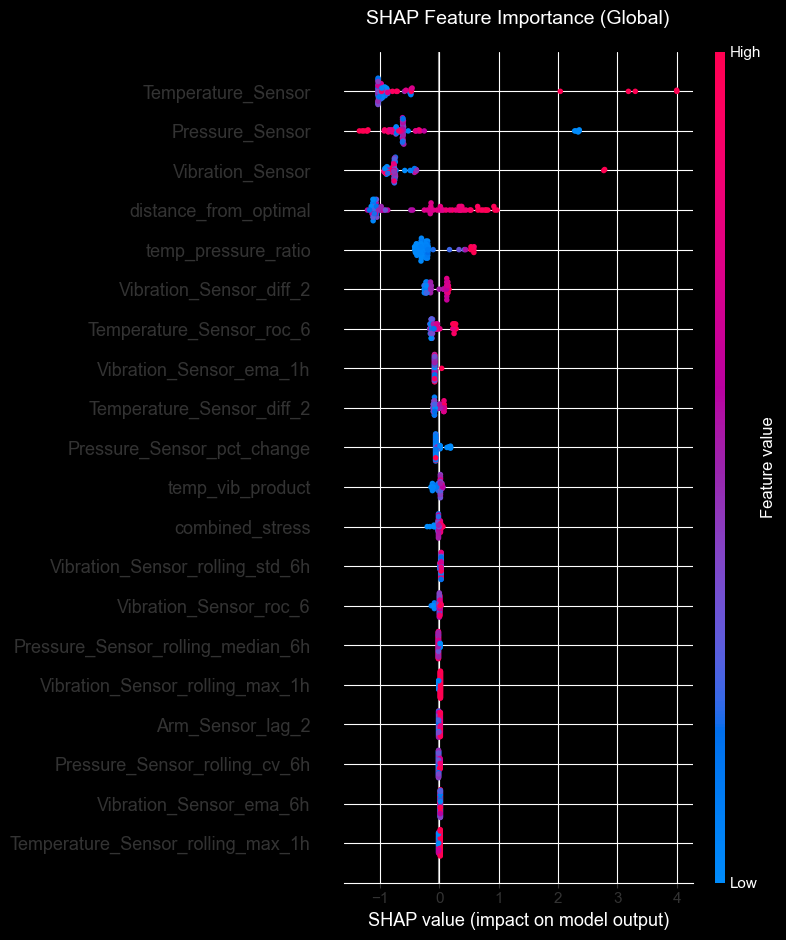

✅ Saved: shap_global_importance.png


In [202]:
# Summary plot - shows importance and impact of all features
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_val_sample,
                 feature_names=feature_columns,
                 show=False)
plt.title('SHAP Feature Importance (Global)', fontsize=14, pad=20)
plt.tight_layout()
plt.savefig('shap_global_importance.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Saved: shap_global_importance.png")

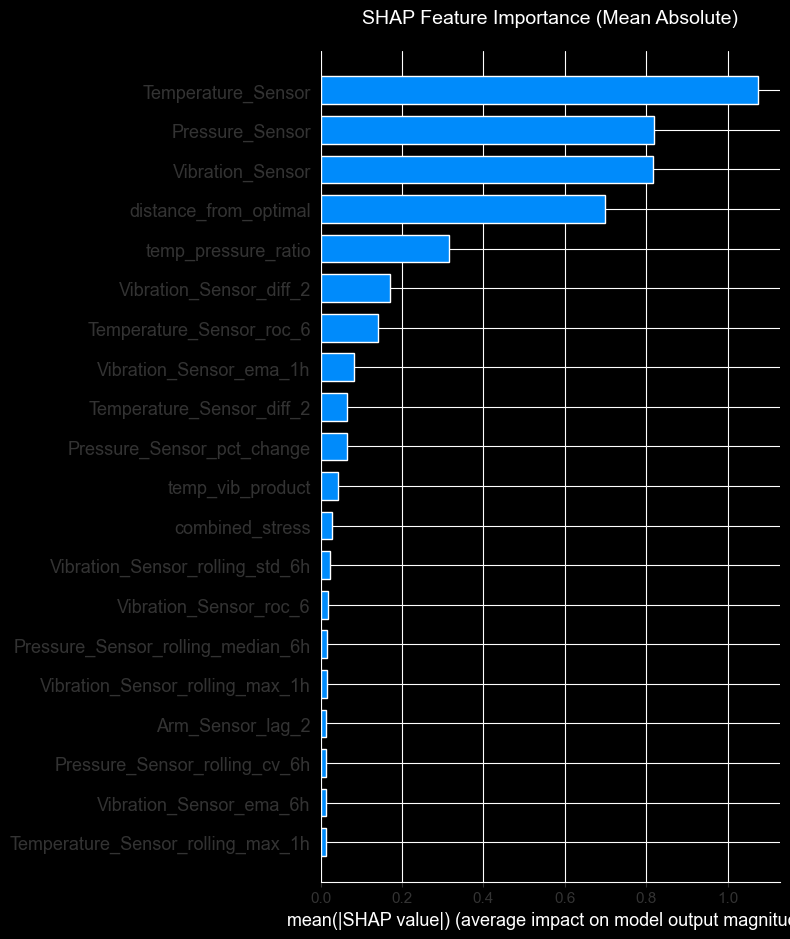

✅ Saved: shap_bar_importance.png


In [203]:
# Bar plot - average absolute SHAP values
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_val_sample,
                 feature_names=feature_columns,
                 plot_type="bar",
                 show=False)
plt.title('SHAP Feature Importance (Mean Absolute)', fontsize=14, pad=20)
plt.tight_layout()
plt.savefig('shap_bar_importance.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Saved: shap_bar_importance.png")

In [204]:
# 2. LOCAL EXPLANATIONS - Individual Predictions
print("\n" + "="*60)
print("LOCAL EXPLANATIONS - Why did the model predict failure?")
print("="*60)


LOCAL EXPLANATIONS - Why did the model predict failure?


In [205]:
# Find a failure prediction to explain
failure_indices = np.where(final_model.predict(X_val_sample) == 1)[0]


Explaining prediction for sample 13:
Predicted: FAILURE
Probability: 0.9269


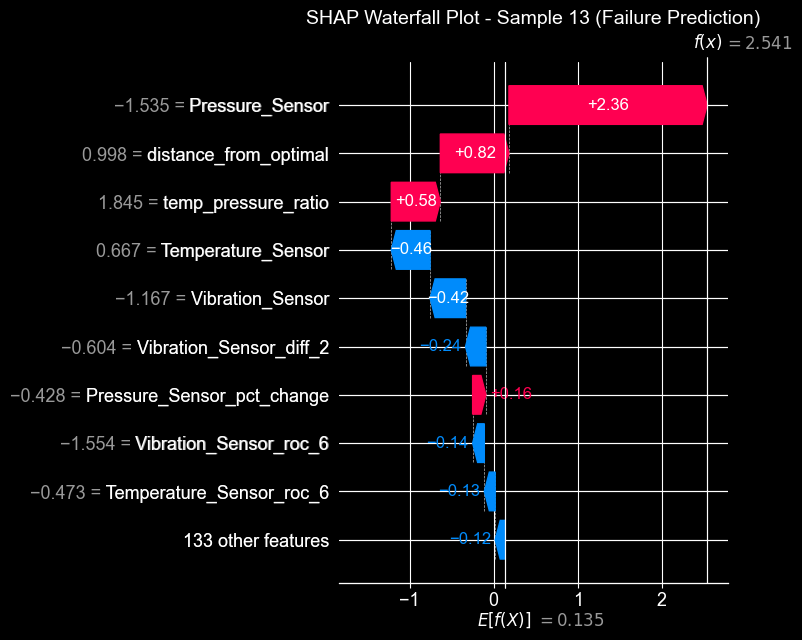

✅ Saved: shap_waterfall_sample_13.png


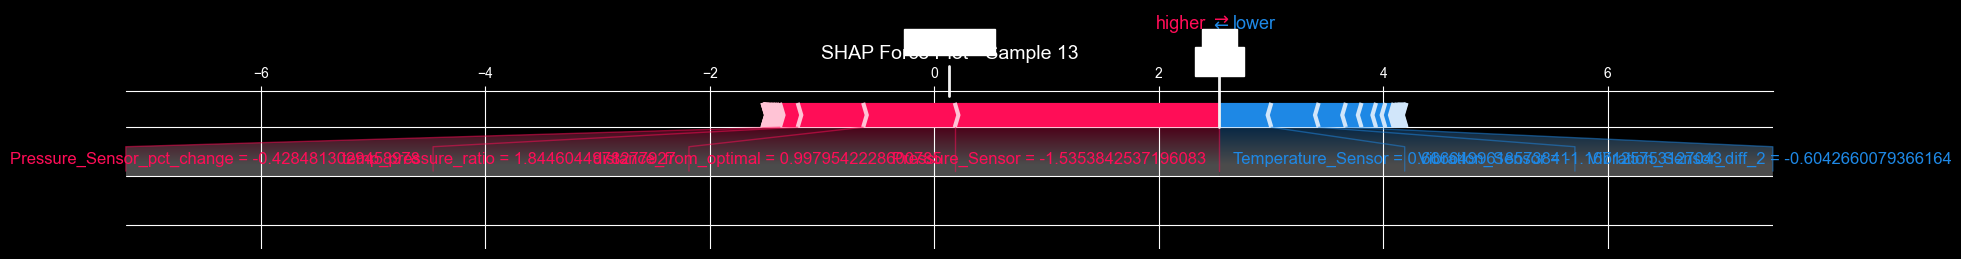

✅ Saved: shap_force_sample_13.png

📊 Top Contributing Features:
                   Feature   Value  SHAP_Value
           Pressure_Sensor -1.5354      2.3584
     distance_from_optimal  0.9980      0.8163
       temp_pressure_ratio  1.8446      0.5835
        Temperature_Sensor  0.6666     -0.4617
          Vibration_Sensor -1.1671     -0.4218
   Vibration_Sensor_diff_2 -0.6043     -0.2426
Pressure_Sensor_pct_change -0.4285      0.1584
    Vibration_Sensor_roc_6 -1.5541     -0.1393
  Temperature_Sensor_roc_6 -0.4726     -0.1294
   Vibration_Sensor_ema_1h -0.7519     -0.0827

💬 EXPLANATION FOR MAINTENANCE ENGINEER:
------------------------------------------------------------
------------------------------------------------------------


In [206]:
if len(failure_indices) > 0:
    # Explain the first failure prediction
    idx = failure_indices[0]

    print(f"\nExplaining prediction for sample {idx}:")
    print(f"Predicted: FAILURE")
    print(f"Probability: {final_model.predict_proba(X_val_sample)[idx, 1]:.4f}")

    # Waterfall plot - shows how each feature contributes
    plt.figure(figsize=(10, 8))
    shap.waterfall_plot(shap.Explanation(
        values=shap_values[idx],
        base_values=explainer.expected_value,
        data=X_val_sample[idx],
        feature_names=feature_columns
    ), show=False)
    plt.title(f'SHAP Waterfall Plot - Sample {idx} (Failure Prediction)', fontsize=14)
    plt.tight_layout()
    plt.savefig(f'shap_waterfall_sample_{idx}.png', dpi=300, bbox_inches='tight')
    plt.show()

    print(f"✅ Saved: shap_waterfall_sample_{idx}.png")

    # Force plot - shows contribution of each feature
    shap.force_plot(
        explainer.expected_value,
        shap_values[idx],
        X_val_sample[idx],
        feature_names=feature_columns,
        matplotlib=True,
        show=False
    )
    plt.title(f'SHAP Force Plot - Sample {idx}', fontsize=14)
    plt.tight_layout()
    plt.savefig(f'shap_force_sample_{idx}.png', dpi=300, bbox_inches='tight')
    plt.show()

    print(f"✅ Saved: shap_force_sample_{idx}.png")

    # Create human-readable explanation
    feature_contributions = pd.DataFrame({
        'Feature': feature_columns,
        'Value': X_val_sample[idx],
        'SHAP_Value': shap_values[idx]
    }).sort_values('SHAP_Value', key=abs, ascending=False)

    print("\n📊 Top Contributing Features:")
    print(feature_contributions.head(10).to_string(index=False))

    # Generate natural language explanation
    print("\n💬 EXPLANATION FOR MAINTENANCE ENGINEER:")
    print("-" * 60)

    top_features = feature_contributions.head(5)
    explanation_parts = []

    for _, row in top_features.iterrows():
        feature = row['Feature']
        value = row['Value']
        shap_val = row['SHAP_Value']

        if 'rolling_mean' in feature:
            explanation_parts.append(
                f"• The rolling average of {feature.split('_')[0]} "
                f"is {value:.2f}, which {'increases' if shap_val > 0 else 'decreases'} "
                f"failure risk significantly."
            )
        elif 'temperature' in feature:
            explanation_parts.append(
                f"• Temperature reading ({value:.2f}°C) "
                f"{'exceeds safe operating limits' if shap_val > 0 else 'is within normal range'}."
            )
        elif 'vibration' in feature:
            explanation_parts.append(
                f"• Vibration level ({value:.2f} Hz) "
                f"{'indicates mechanical stress' if shap_val > 0 else 'is normal'}."
            )
        elif 'rolling_std' in feature:
            explanation_parts.append(
                f"• High variability detected in {feature.split('_')[0]} "
                f"(std={value:.2f}), suggesting unstable conditions."
            )

    for part in explanation_parts:
        print(part)

    print("-" * 60)
else:
    print("No failure predictions found in sample.")

In [207]:
# 3. DEPENDENCE PLOTS - Show relationship between features
print("\n" + "="*60)
print("SHAP DEPENDENCE PLOTS")
print("="*60)


SHAP DEPENDENCE PLOTS


In [208]:
# Plot for top 3 most important features
top_3_features = feature_importance.head(3)['Feature'].tolist()

<Figure size 1000x600 with 0 Axes>

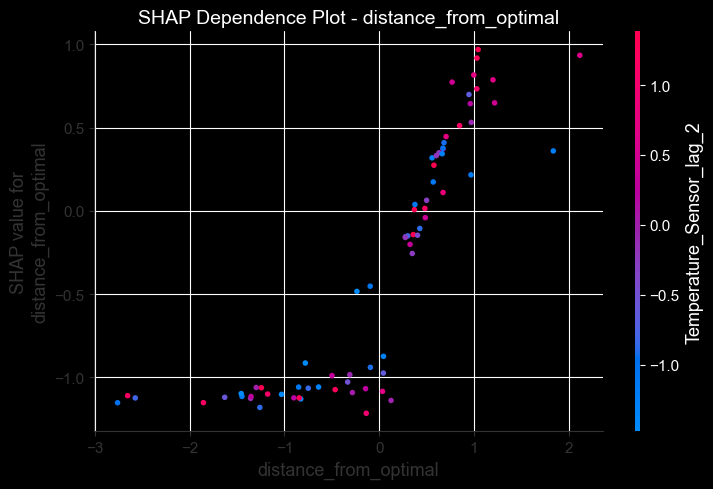

✅ Saved: shap_dependence_distance_from_optimal.png


<Figure size 1000x600 with 0 Axes>

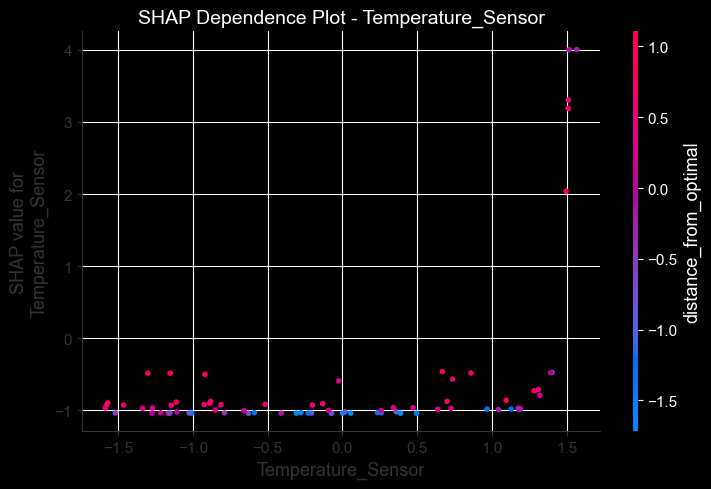

✅ Saved: shap_dependence_Temperature_Sensor.png


<Figure size 1000x600 with 0 Axes>

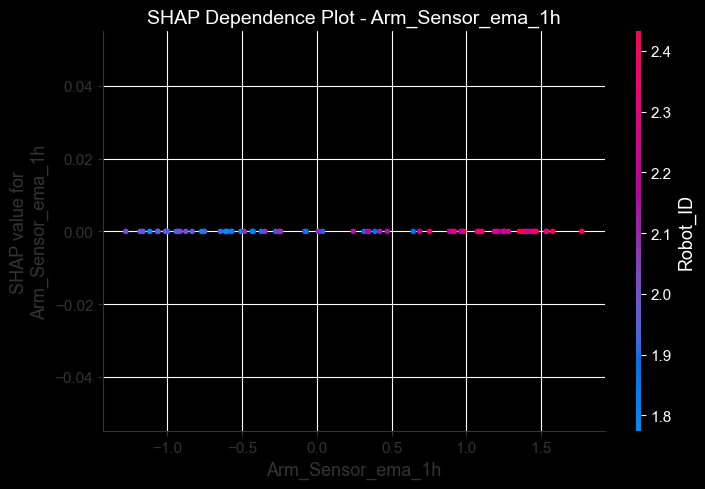

✅ Saved: shap_dependence_Arm_Sensor_ema_1h.png


In [209]:
for i, feature in enumerate(top_3_features):
    if feature in feature_columns:
        feature_idx = feature_columns.index(feature)

        plt.figure(figsize=(10, 6))
        shap.dependence_plot(
            feature_idx,
            shap_values,
            X_val_sample,
            feature_names=feature_columns,
            show=False
        )
        plt.title(f'SHAP Dependence Plot - {feature}', fontsize=14)
        plt.tight_layout()
        plt.savefig(f'shap_dependence_{feature}.png', dpi=300, bbox_inches='tight')
        plt.show()

        print(f"✅ Saved: shap_dependence_{feature}.png")
